# Initial setting

## libraries

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import re
import requests
from time import sleep
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from collections import OrderedDict

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## dataset

In [3]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

In [4]:
df.shape

(100995, 146)

In [5]:
df.head()

,sofifa_id,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,release_clause_eur,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,year,league_name,d_trait_Cautious_With_Crosses,d_trait_Injury_Prone,d_trait_Avoids_Using_Weaker_Foot,d_trait_Backs_Into_Player,d_trait_Flair,d_trait_Saves_with_Feet,d_trait_Leadership,d_trait_Inflexible,d_trait_Finesse_Shot,d_trait_Team_Player,d_trait_1-on-1_Rush,d_trait_Set_Play_Specialist,d_trait_Rushes_Out_Of_Goal,d_trait_Beat_Offside_Trap,d_trait_Early_Crosser,d_trait_Second_Wind,d_trait_Through_Ball,d_trait_Long_Throw-in,d_trait_Giant_Throw-in,d_trait_Diver,d_trait_Acrobatic_Clearance,d_trait_Selfish,d_trait_GK_Up_for_Corners,d_trait_Argues_with_Officials,d_trait_Takes_Finesse_Free_Kicks,...,d_pos_GK,ab_pace,ab_shooting,ab_passing,ab_dribbling,ab_defending,ab_physic,ab_skill_moves,ab_gk_diving,ab_gk_handling,ab_gk_kicking,ab_gk_reflexes,ab_gk_speed,ab_gk_positioning,ab_attacking_crossing,ab_attacking_finishing,ab_attacking_heading_accuracy,ab_attacking_short_passing,ab_attacking_volleys,ab_skill_dribbling,ab_skill_curve,ab_skill_fk_accuracy,ab_skill_long_passing,ab_skill_ball_control,ab_movement_acceleration,ab_movement_sprint_speed,ab_movement_agility,ab_movement_reactions,ab_movement_balance,ab_power_shot_power,ab_power_jumping,ab_power_stamina,ab_power_strength,ab_power_long_shots,ab_mentality_aggression,ab_mentality_interceptions,ab_mentality_positioning,ab_mentality_vision,ab_mentality_penalties,ab_mentality_composure,ab_defending_marking,ab_defending_standing_tackle,ab_defending_sliding_tackle,ab_goalkeeping_diving,ab_goalkeeping_handling,ab_goalkeeping_kicking,ab_goalkeeping_positioning,ab_goalkeeping_reflexes,d_foot_left,d_div1_league
0,158023,L. Messi,27,1987-06-24,169,67,Argentina,FC Barcelona,93,0,0,Left,5,3,4,Medium/Low,Normal,NaN,CF,10.0,NaN,2004-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,89.0,86.0,96.0,27.0,63.0,4,NaN,NaN,NaN,NaN,NaN,NaN,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,1,1
1,20801,Cristiano Ronaldo,29,1985-02-05,185,80,Portugal,Real Madrid,92,0,0,Right,5,4,5,High/Low,Normal,NaN,LW,7.0,NaN,2009-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,93.0,81.0,91.0,32.0,79.0,5,NaN,NaN,NaN,NaN,NaN,NaN,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,0,1
2,9014,A. Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,90,0,0,Left,5,2,4,High/Low,Normal,NaN,SUB,10.0,NaN,2009-08-28,2017.0,2015,German 1. Bundesliga,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,93.0,86.0,83.0,92.0,32.0,64.0,4,NaN,NaN,NaN,NaN,NaN,NaN,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,1,1
3,41236,Z. Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,90,0,0,Right,5,4,4,Medium/Low,Normal,NaN,ST,10.0,NaN,2012-07-01,2016.0,2015,French Ligue 1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,76.0,91.0,81.0,86.0,34.0,86.0,4,NaN,NaN,NaN,NaN,NaN,NaN,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,NaN,25,41,27,13,15,10,9,12,0,1
4,167495,M. Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,90,0,0,Right,5,4,1,Medium/Medium,Normal,NaN,GK,1.0,NaN,2011-07-01,2019.0,2015,German 1. Bundesliga,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,87.0,85.0,92.0,86.0,60.0,90.0,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,NaN,25,25,25,87,85,92,90,86,0,1


# PartD

In [6]:
skills = []
for i in list(df.columns):
    if 'skill' in i:
        skills.append(i)
skills

['skill_moves',
 'ab_skill_moves',
 'ab_skill_dribbling',
 'ab_skill_curve',
 'ab_skill_fk_accuracy',
 'ab_skill_long_passing',
 'ab_skill_ball_control']

We decided to predict ball_control skill score among other skills

## predict ball_control skill score in 2020 from the data in 2019

In [21]:
import xgboost as xgb

In [7]:
# get 2019 and 2020 data for training
df_2019 = df[df['year']==2019]
df_2020 = df[df['year']==2020]

In [8]:
# drop variables other than 'ball_control' from df_2020
df_2020_sk = df_2020[['sofifa_id', 'ab_skill_ball_control']]
df_2020_sk = df_2020_sk.rename({'ab_skill_ball_control': '2020_ball_control'})

In [9]:
# merge with df_2019
df_1920 = df_2019.merge(df_2020_sk, on='sofifa_id', how='left', suffixes=(None, '_r'))

In [10]:
# drop rows that includes nan value
df_1920.dropna(subset=['ab_skill_ball_control_r'], inplace=True)

In [12]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club']
df_1920_drop = df_1920.drop(drop_vars, axis=1)

# drop rows that do not contain enough information in primary ability variables (e.g. ab_pace)
df_1920_drop = df_1920_drop[-df_1920_drop.ab_pace.isna()]
#df_a_all = df_a_all[df_a_all.d_div1_league == 1]

# impute zero values for release_clause and goalkeeping ability
# this is because goalkeeping ability is not available for field players
impute_vars = ['release_clause_eur'] + [x for x in df_1920.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_1920_drop[var] = df_1920_drop[var].fillna(0)

# select players in the following clubs as test set
select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
df_d_test = df_1920_drop[df_1920_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
df_d_train = df_1920_drop[-df_1920_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
print(df_d_train.shape, df_d_test.shape)

(9347, 130) (2329, 130)


In [13]:
# separate X and y
y_train = df_d_train['ab_skill_ball_control_r']
y_test = df_d_test['ab_skill_ball_control_r']
X_train = df_d_train.drop(['ab_skill_ball_control_r'], axis=1) #, 'ab_skill_ball_control_x'
X_test = df_d_test.drop(['ab_skill_ball_control_r'], axis=1) # , 'ab_skill_ball_control_x'

In [14]:
# create test and validation set
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=81)

In [22]:
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [23]:
params = {'objective': 'reg:squarederror', 
          'booster': 'gbtree', 
          'eta': 0.05,
          'gamma': 0.0,
          'alpha': 0.0,
          'lambda': 1.0,
#           'min_chid_weight': 1,
          'max_depth': 5,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'random_state': 81
          }
num_round = 100000

In [24]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=50)

[0]	train-rmse:60.80092	eval-rmse:60.58823
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:57.77936	eval-rmse:57.57395
[2]	train-rmse:54.90579	eval-rmse:54.70820
[3]	train-rmse:52.17415	eval-rmse:51.98439
[4]	train-rmse:49.57883	eval-rmse:49.39675
[5]	train-rmse:47.11475	eval-rmse:46.94146
[6]	train-rmse:44.77945	eval-rmse:44.61272
[7]	train-rmse:42.55669	eval-rmse:42.39631
[8]	train-rmse:40.44524	eval-rmse:40.29107
[9]	train-rmse:38.43936	eval-rmse:38.29130
[10]	train-rmse:36.54077	eval-rmse:36.39764
[11]	train-rmse:34.73302	eval-rmse:34.59689
[12]	train-rmse:33.01375	eval-rmse:32.88510
[13]	train-rmse:31.38262	eval-rmse:31.25945
[14]	train-rmse:29.83192	eval-rmse:29.71446
[15]	train-rmse:28.36110	eval-rmse:28.24886
[16]	train-rmse:26.96398	eval-rmse:26.85821
[17]	train-rmse:25.63548	eval-rmse:25.53377
[18]	train-rmse:24.37513	eval-rmse:24.27720
[19]	train-rmse:23.17921	eval-r

[189]	train-rmse:2.31651	eval-rmse:3.06377
[190]	train-rmse:2.31450	eval-rmse:3.06418
[191]	train-rmse:2.31036	eval-rmse:3.06364
Stopping. Best iteration:
[141]	train-rmse:2.45647	eval-rmse:3.05719



In [25]:
va_pred = model.predict(dvalid)
te_pred = model.predict(dtest)

val_score = mean_squared_error(y_val, va_pred)
test_score = mean_squared_error(y_test, te_pred)

print(f'Validation MSE: {val_score:.3f}, test MSE: {test_score:3f}.')

Validation MSE: 9.386, test MSE: 8.529599.


## hyper parameter tuning with hyperopt

In [26]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import log_loss

In [27]:
# grid search

param_space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
    'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
    'booster': hp.choice('booster', ['gblinear', 'dart', 'gbtree'])
}

In [28]:
def score(params):
    params['max_depth'] = int(params['max_depth'])
    
    model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=50)
    va_pred = model.predict(dvalid)
    te_pred = model.predict(dtest)

    val_score = mean_squared_error(y_val, va_pred)
#     test_score = mean_squared_error(y_test, te_pred)
    print(f'params: {params}, MSE: {val_score:.3f}')
    history.append((params, val_score))
    return {'loss': val_score, 'status': STATUS_OK}

In [29]:
max_evals = 10
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

[0]	train-rmse:45.02729	eval-rmse:44.86747            

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 50 rounds.

[1]	train-rmse:31.71214	eval-rmse:31.57947            

[2]	train-rmse:22.41318	eval-rmse:22.29658            

[3]	train-rmse:15.93970	eval-rmse:15.84430            

[4]	train-rmse:11.44949	eval-rmse:11.37868            

[5]	train-rmse:8.38299	eval-rmse:8.33458              

[6]	train-rmse:6.34120	eval-rmse:6.31840              

[7]	train-rmse:5.02391	eval-rmse:5.01523              

[8]	train-rmse:4.20826	eval-rmse:4.21712              

[9]	train-rmse:3.73284	eval-rmse:3.75055              

[10]	train-rmse:3.46486	eval-rmse:3.49542             

[11]	train-rmse:3.31424	eval-rmse:3.35414             

[12]	train-rmse:3.23696	eval-rmse:3.29427             

[13]	train-rmse:3.18818	eval-rmse:3.25687             

[14]	train-rmse:3.15328	eval-rmse:3.23393             

[15]	train-rmse

[28]	train-rmse:1.96353	eval-rmse:3.25939                                      

[29]	train-rmse:1.93361	eval-rmse:3.26130                                      

[30]	train-rmse:1.89641	eval-rmse:3.26432                                      

[31]	train-rmse:1.88468	eval-rmse:3.26529                                      

[32]	train-rmse:1.86519	eval-rmse:3.26887                                      

[33]	train-rmse:1.83724	eval-rmse:3.27074                                      

[34]	train-rmse:1.80306	eval-rmse:3.27726                                      

[35]	train-rmse:1.79488	eval-rmse:3.27850                                      

[36]	train-rmse:1.78252	eval-rmse:3.27826                                      

[37]	train-rmse:1.75400	eval-rmse:3.28026                                      

[38]	train-rmse:1.72777	eval-rmse:3.28745                                      

[39]	train-rmse:1.70034	eval-rmse:3.29384                                      

[40]	train-rmse:1.67143	eval

[53]	train-rmse:2.10796	eval-rmse:3.32897                                      

[54]	train-rmse:2.09672	eval-rmse:3.32979                                      

[55]	train-rmse:2.08724	eval-rmse:3.33202                                      

[56]	train-rmse:2.08113	eval-rmse:3.33340                                      

[57]	train-rmse:2.06482	eval-rmse:3.33382                                      

[58]	train-rmse:2.05342	eval-rmse:3.33483                                      

[59]	train-rmse:2.04245	eval-rmse:3.33788                                      

[60]	train-rmse:2.02596	eval-rmse:3.34166                                      

[61]	train-rmse:2.01300	eval-rmse:3.35493                                      

[62]	train-rmse:1.99894	eval-rmse:3.36194                                      

[63]	train-rmse:1.98475	eval-rmse:3.36961                                      

[64]	train-rmse:1.98043	eval-rmse:3.36678                                      

[65]	train-rmse:1.97904	eval

[3]	train-rmse:15.69407	eval-rmse:15.62886                                     

[4]	train-rmse:11.20324	eval-rmse:11.16739                                     

[5]	train-rmse:8.12510	eval-rmse:8.13302                                       

[6]	train-rmse:6.06264	eval-rmse:6.11190                                       

[7]	train-rmse:4.71963	eval-rmse:4.81628                                       

[8]	train-rmse:3.89800	eval-rmse:4.04222                                       

[9]	train-rmse:3.39750	eval-rmse:3.59891                                       

[10]	train-rmse:3.12603	eval-rmse:3.36341                                      

[11]	train-rmse:2.97546	eval-rmse:3.25069                                      

[12]	train-rmse:2.89194	eval-rmse:3.21310                                      

[13]	train-rmse:2.83570	eval-rmse:3.19775                                      

[14]	train-rmse:2.79367	eval-rmse:3.15718                                      

[15]	train-rmse:2.76570	eval

[30]	train-rmse:2.03213	eval-rmse:3.24160                                      

[31]	train-rmse:2.01506	eval-rmse:3.24465                                      

[32]	train-rmse:1.99543	eval-rmse:3.25478                                      

[33]	train-rmse:1.97143	eval-rmse:3.26199                                      

[34]	train-rmse:1.95035	eval-rmse:3.26574                                      

[35]	train-rmse:1.93069	eval-rmse:3.26766                                      

[36]	train-rmse:1.91011	eval-rmse:3.27149                                      

[37]	train-rmse:1.88488	eval-rmse:3.27910                                      

[38]	train-rmse:1.87040	eval-rmse:3.27322                                      

[39]	train-rmse:1.85448	eval-rmse:3.27793                                      

[40]	train-rmse:1.83785	eval-rmse:3.28043                                      

[41]	train-rmse:1.81204	eval-rmse:3.28085                                      

[42]	train-rmse:1.79387	eval

[59]	train-rmse:1.77155	eval-rmse:3.31654                                      

[60]	train-rmse:1.75823	eval-rmse:3.32370                                      

[61]	train-rmse:1.74245	eval-rmse:3.32394                                      

[62]	train-rmse:1.73066	eval-rmse:3.32642                                      

[63]	train-rmse:1.72151	eval-rmse:3.33081                                      

[64]	train-rmse:1.71758	eval-rmse:3.33533                                      

[65]	train-rmse:1.69809	eval-rmse:3.33916                                      

Stopping. Best iteration:                                                      
[15]	train-rmse:2.46957	eval-rmse:3.18691


params: {'alpha': 0.003419652313695628, 'booster': 'dart', 'colsample_bytree': 0.65, 'gamma': 2.0949861452181433e-08, 'lambda': 1.4619654471397705e-06, 'max_depth': 6, 'min_child_weight': 8.159192982893655, 'subsample': 0.75}, MSE: 11.150
[0]	train-rmse:44.90787	eval-rmse:44.73093                            

[14]	train-rmse:2.55130	eval-rmse:3.27702                                      

[15]	train-rmse:2.49920	eval-rmse:3.27242                                      

[16]	train-rmse:2.48419	eval-rmse:3.27339                                      

[17]	train-rmse:2.46064	eval-rmse:3.27161                                      

[18]	train-rmse:2.44006	eval-rmse:3.28435                                      

[19]	train-rmse:2.41027	eval-rmse:3.28770                                      

[20]	train-rmse:2.39928	eval-rmse:3.29026                                      

[21]	train-rmse:2.38872	eval-rmse:3.28982                                      

[22]	train-rmse:2.38055	eval-rmse:3.29785                                      

[23]	train-rmse:2.36765	eval-rmse:3.30327                                      

[24]	train-rmse:2.34973	eval-rmse:3.31486                                      

[25]	train-rmse:2.33434	eval-rmse:3.31605                                      

[26]	train-rmse:2.29834	eval

[40]	train-rmse:2.27689	eval-rmse:3.24902                                      

[41]	train-rmse:2.26303	eval-rmse:3.24890                                      

[42]	train-rmse:2.25181	eval-rmse:3.25090                                      

[43]	train-rmse:2.24684	eval-rmse:3.25403                                      

[44]	train-rmse:2.23973	eval-rmse:3.25370                                      

[45]	train-rmse:2.23354	eval-rmse:3.25535                                      

[46]	train-rmse:2.22593	eval-rmse:3.25831                                      

[47]	train-rmse:2.21173	eval-rmse:3.26286                                      

[48]	train-rmse:2.19380	eval-rmse:3.26307                                      

[49]	train-rmse:2.18734	eval-rmse:3.25998                                      

[50]	train-rmse:2.17757	eval-rmse:3.25558                                      

[51]	train-rmse:2.16850	eval-rmse:3.25254                                      

[52]	train-rmse:2.15487	eval

{'alpha': 0.34694203711803556,
 'booster': 1,
 'colsample_bytree': 0.9,
 'gamma': 2.6533922214870612e-06,
 'lambda': 7.980972096910402,
 'max_depth': 3.0,
 'min_child_weight': 1.9506198274315276,
 'subsample': 0.8500000000000001}

In [30]:
history = sorted(history, key=lambda tpl: tpl[1])
best = history[0]
print(f'best params: {best[0]}, score:{best[1]:.3f}')

best params: {'alpha': 0.34694203711803556, 'booster': 'dart', 'colsample_bytree': 0.9, 'gamma': 2.6533922214870612e-06, 'lambda': 7.980972096910402, 'max_depth': 3, 'min_child_weight': 1.9506198274315276, 'subsample': 0.8500000000000001}, score:9.908


## Run XGBOOST with best parameters

In [31]:
best_params = {'objective': 'reg:squarederror', 
          'booster': best[0]['booster'],
          'eta': 0.05,
          'gamma': best[0]['gamma'],
          'alpha': best[0]['alpha'],
          'lambda': best[0]['lambda'],
          'min_chid_weight': best[0]['min_child_weight'],
          'max_depth': best[0]['max_depth'],
          'subsample': best[0]['subsample'],
          'colsample_bytree': best[0]['colsample_bytree'],
          'random_state': 81
          }
num_round = 100000

In [32]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(best_params, dtrain, num_round, evals=watchlist, early_stopping_rounds=50)

[09:05:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_chid_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:60.81211	eval-rmse:60.60319
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:57.80833	eval-rmse:57.60880
[2]	train-rmse:54.94912	eval-rmse:54.75725
[3]	train-rmse:52.23109	eval-rmse:52.04721
[4]	train-rmse:49.64965	eval-rmse:49.47311
[5]	train-rmse:47.19745	eval-rmse:47.02542
[6]	train-rmse:44.86747	eval-rmse:44.70169
[7]	train-rmse:42.65331	eval-rmse:42.49022
[8]	train-rmse:40.54923	eval-rmse:40.39395
[9]	train-rmse:38.55103	eval-rmse:38.40251
[10]	train-rmse:36.65684	eval-rmse

[179]	train-rmse:2.86644	eval-rmse:3.08224
[180]	train-rmse:2.86501	eval-rmse:3.08123
[181]	train-rmse:2.86385	eval-rmse:3.08160
[182]	train-rmse:2.86279	eval-rmse:3.08123
[183]	train-rmse:2.86092	eval-rmse:3.08143
[184]	train-rmse:2.85892	eval-rmse:3.08200
[185]	train-rmse:2.85824	eval-rmse:3.08214
[186]	train-rmse:2.85682	eval-rmse:3.08157
[187]	train-rmse:2.85524	eval-rmse:3.08120
[188]	train-rmse:2.85248	eval-rmse:3.08087
[189]	train-rmse:2.85081	eval-rmse:3.08121
[190]	train-rmse:2.84937	eval-rmse:3.08179
[191]	train-rmse:2.84748	eval-rmse:3.08176
[192]	train-rmse:2.84577	eval-rmse:3.08128
[193]	train-rmse:2.84476	eval-rmse:3.08138
[194]	train-rmse:2.84337	eval-rmse:3.08119
[195]	train-rmse:2.84153	eval-rmse:3.08081
[196]	train-rmse:2.84081	eval-rmse:3.08107
[197]	train-rmse:2.83988	eval-rmse:3.08137
[198]	train-rmse:2.83754	eval-rmse:3.08296
[199]	train-rmse:2.83634	eval-rmse:3.08199
[200]	train-rmse:2.83410	eval-rmse:3.08230
Stopping. Best iteration:
[150]	train-rmse:2.91238	eva

In [33]:
va_pred = model.predict(dvalid)
te_pred = model.predict(dtest)

val_score = mean_squared_error(y_val, va_pred)
test_score = mean_squared_error(y_test, te_pred)

print(f'Validation MSE: {val_score:.3f}, test MSE: {test_score:3f}.')

Validation MSE: 9.501, test MSE: 8.882531.


## predict 2021 ball_control skill score from 2020 data

First, pre-process the data again (in the same way that we did above), and subset 2020 data to only includes selected teams

In [34]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club']
df_2020_drop = df_2020.drop(drop_vars, axis=1)

# drop rows that do not contain enough information in primary ability variables (e.g. ab_pace)
df_2020_drop = df_2020_drop[-df_2020_drop.ab_pace.isna()]

# impute zero values for release_clause and goalkeeping ability
# this is because goalkeeping ability is not available for field players
impute_vars = ['release_clause_eur'] + [x for x in df_2020.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_2020_drop[var] = df_2020_drop[var].fillna(0)

# select players in the following clubs as test set
select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
df_2020_test = df_2020_drop[df_2020_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
print(df_2020_test.shape)

(2708, 129)


In [35]:
# making prediction for 2021 ball_control skill score
dtest_2021 = xgb.DMatrix(df_2020_test)
prediction_2021 = model.predict(dtest_2021)

## EDA: change in ball_control skill score between 2019 and 2020

In [36]:
df_ball_control = df_1920_drop[['ab_skill_ball_control', 'ab_skill_ball_control_r']]
df_ball_control['diff'] = df_ball_control['ab_skill_ball_control_r'] - df_ball_control['ab_skill_ball_control']

C:\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([2.000e+00, 4.000e+00, 9.000e+00, 5.600e+01, 3.450e+02, 9.240e+02,
        7.154e+03, 1.892e+03, 5.470e+02, 3.910e+02, 1.670e+02, 5.500e+01,
        5.900e+01, 3.800e+01, 9.000e+00, 1.200e+01, 6.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00]),
 array([-17.  , -14.35, -11.7 ,  -9.05,  -6.4 ,  -3.75,  -1.1 ,   1.55,
          4.2 ,   6.85,   9.5 ,  12.15,  14.8 ,  17.45,  20.1 ,  22.75,
         25.4 ,  28.05,  30.7 ,  33.35,  36.  ]),
 <BarContainer object of 20 artists>)

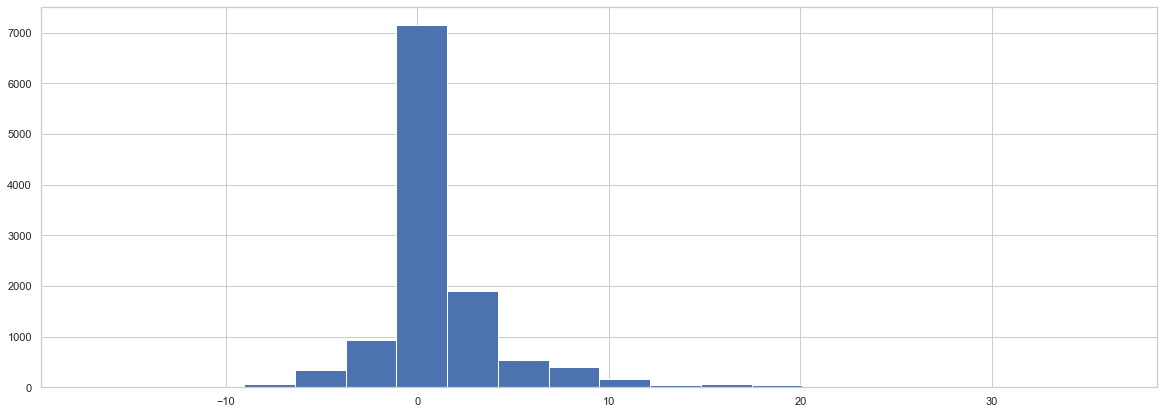

In [37]:
plt.figure(figsize = (20, 7))
plt.hist(x=df_ball_control['diff'], bins=20)